In [208]:
import pandas as pd
import numpy as np
import datetime as dt

from tensorflow import keras
import tensorflow as tf
from keras.utils import timeseries_dataset_from_array

import plotly.express as px
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

### Importación de datos

Leemos el archivo y ordenamos por datetime

In [209]:
data_df = pd.read_csv('data_training/esios_data_modelo_dl.csv')
data_df['Datetime_hour'] = pd.to_datetime(data_df['Datetime_hour'])
data_df['day_of_week'] = data_df['Datetime_hour'].dt.dayofweek
data_df = data_df.sort_values(by=['Datetime_hour']).reset_index(drop=True)
data_df

,Datetime_hour,Gen.P48 Fotovoltaica,MD,IDA1,IDA2,Gen.P48 Eolica,Interconexiones P48,Demanda P48,Gen.P48 Total,day_of_week
0,2023-12-31 23:00:00,2.8,63.33,54.33,57.00,5520.1,525.9,21979.3,22640.6,6
1,2024-01-01 00:00:00,5.5,50.09,45.54,46.54,5528.0,229.7,21532.5,22561.3,0
2,2024-01-01 01:00:00,4.3,47.50,40.50,41.80,5155.8,-370.0,19869.1,21713.1,0
3,2024-01-01 02:00:00,2.7,43.50,38.95,34.53,4958.0,-58.1,18569.4,20250.0,0
4,2024-01-01 03:00:00,2.7,42.50,33.50,33.50,4915.2,-258.9,17979.8,20159.5,0
...,...,...,...,...,...,...,...,...,...,...
13867,2025-07-31 18:00:00,3933.6,107.99,119.91,122.38,9624.1,-2968.9,32146.3,35130.0,3
13868,2025-07-31 19:00:00,309.7,114.45,111.45,111.65,11052.2,-1356.7,32179.0,34616.8,3
13869,2025-07-31 20:00:00,0.3,110.27,109.22,110.22,12185.9,-2681.6,31008.0,35120.6,3
13870,2025-07-31 21:00:00,0.3,98.32,98.52,102.78,12407.5,-3586.2,28579.2,33451.4,3


### Visualización inicial

Visualizamos la forma de la función target para las últimas 2 semanas

In [210]:
px.line(data_df.iloc[-3*24*7:], x='Datetime_hour', y='MD')

### Preparación de datos

In [211]:
def create_sequences(df, input_steps, output_steps, target_column):
    X, y = [], []
    data = df.values
    target_idx = df.columns.get_loc(target_column)

    for i in range(0, len(df) - input_steps - output_steps + 1, 24):
        X.append(data[i:i+input_steps, :])  # Ventana de entrada
        y.append(data[i+input_steps:i+input_steps+output_steps, target_idx])  # Ventana de salida

    return np.array(X), np.array(y)

In [212]:
### PARAMETROS
fecha_inicio = '2024-01-01'
cols_to_drop = ['IDA1', 'IDA2']

porc_train = 0.6
porc_val = 0.2
features = [col for col in data_df.columns if col not in ['Datetime_hour']]

input_steps = 24*3
output_steps = 24

batch_size = 32

In [213]:
# Seleccionar valores
data_df = data_df.loc[data_df['Datetime_hour'] >= fecha_inicio]
data_df = data_df.drop(columns=cols_to_drop)

# Dividir en Train, Val, Test y crear datasets
num_train_samples = int(porc_train*len(data_df))
num_val_samples = int(porc_val*len(data_df))
num_test_samples = len(data_df) - num_train_samples - num_val_samples
print(f"Train: {num_train_samples}, Val: {num_val_samples}, Test: {num_test_samples}")

data_df_input = data_df.drop(columns=['Datetime_hour'])
train_df = data_df_input.iloc[:num_train_samples].copy()
val_df = data_df_input.iloc[num_train_samples:num_train_samples + num_val_samples].copy()
test_df = data_df_input.iloc[num_train_samples + num_val_samples:].copy()



# Escalado de features (X)
predictors = [col for col in train_df.columns if col not in ['MD', 'Datetime_hour']]
x_scaler = StandardScaler()

train_df.loc[:, predictors] = x_scaler.fit_transform(train_df[predictors])
val_df.loc[:, predictors]   = x_scaler.transform(val_df[predictors])
test_df.loc[:, predictors]  = x_scaler.transform(test_df[predictors])


# Escalado de target (y)
y_scaler = StandardScaler()

train_df.loc[:, 'MD'] = y_scaler.fit_transform(train_df[['MD']])
val_df.loc[:, 'MD']   = y_scaler.transform(val_df[['MD']])
test_df.loc[:, 'MD']  = y_scaler.transform(test_df[['MD']])


# Ventanas temporales
X_train, y_train = create_sequences(train_df, input_steps, output_steps, 'MD')
X_val, y_val = create_sequences(val_df, input_steps, output_steps, 'MD')
X_test, y_test = create_sequences(test_df, input_steps, output_steps, 'MD')

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Train: {y_train.shape}, Val: {y_val.shape}, Test: {y_test.shape}")

Train: 8322, Val: 2774, Test: 2775
Train: (343, 72, 7), Val: (112, 72, 7), Test: (112, 72, 7)
Train: (343, 24), Val: (112, 24), Test: (112, 24)


### Calculo del error base

Tenemos que establecer un objetivo de precisión para nuestro modelo. Para ello, suponemos dos pronósticos iniciales:
1. El precio a la misma hora del día anterior
2. El precio a la misma hora y el mismo día de la semana anterior

Consideramos esta segunda posibilidad, debido a la gran diferencia que existe entre los precios en fin de semana y entre semana.

In [197]:
md_true = []
md_delay_day = []
data_array = data_df_input.values

# Calculamos los targets para el dataset sin escalar
for i in range(len(data_array) - input_steps - output_steps):
    md_true.append(data_array[i+input_steps:i+input_steps+output_steps, features.index('MD')])
    # Delay de 1 dia
    md_delay_day.append(data_array[i+input_steps-24:i+input_steps+output_steps-24, features.index('MD')])


md_true = np.array(md_true)
md_delay_day = np.array(md_delay_day)

print(f"MAE day-delay: {np.mean(np.abs(md_true - md_delay_day))}")

MAE day-delay: 19.62972358578775


### Modelo de Redes Neuronales Densas

In [169]:
inputs = keras.Input(shape=(input_steps, X_train.shape[-1]))
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(32, activation="relu")(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")

Epoch 1/30


ValueError: Input 0 of layer "functional_16" is incompatible with the layer: expected shape=(None, 72, 7), found shape=(None, 168, 8)

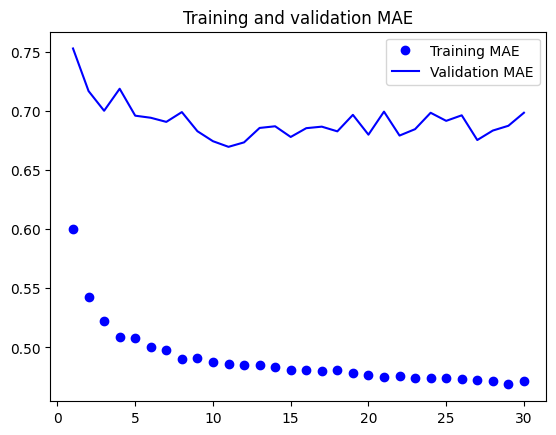

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Modelo LSTM

In [198]:
### PARAMETROS
dropout = 0.2
n_neurons = 128
r_drop = 0.25
patience = 15
lr = 0.0005
n_epochs = 100
regularizer = keras.regularizers.l2(1e-4)

In [199]:
inputs = keras.Input(shape=(input_steps, data_array.shape[-1]))
x = keras.layers.LSTM(n_neurons, recurrent_dropout=r_drop, activation='tanh', return_sequences=True, kernel_regularizer=regularizer)(inputs)
x = keras.layers.Dropout(dropout)(x)
x = keras.layers.LSTM(n_neurons, recurrent_dropout=r_drop, activation='tanh', return_sequences=False, kernel_regularizer=regularizer)(inputs)
x = keras.layers.Dropout(dropout)(x)
outputs = keras.layers.Dense(24)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
]

optimizer = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.9820 - mae: 0.8554 - val_loss: 0.8592 - val_mae: 0.8433
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.8307 - mae: 0.7923 - val_loss: 0.7408 - val_mae: 0.7748
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6619 - mae: 0.6917 - val_loss: 0.6404 - val_mae: 0.6911
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5143 - mae: 0.5939 - val_loss: 0.5767 - val_mae: 0.6251
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4324 - mae: 0.5320 - val_loss: 0.5633 - val_mae: 0.6079
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4081 - mae: 0.5116 - val_loss: 0.5976 - val_mae: 0.6255
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3714 - mae: 0.4811 - val_loss: 0.6395 - val_mae: 0.6397
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3197 - mae: 0.4395 - val_loss: 0.6438 - val_mae: 0.6374
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3193 - mae: 

Evolución del entrenamiento

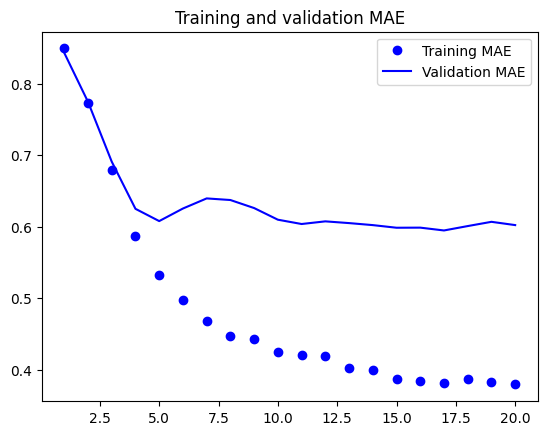

In [200]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Evaluación del test y visualización de resultados

In [201]:
model = keras.models.load_model("jena_lstm_dropout.keras")
y_pred = model.predict(X_test)

y_pred_rescaled = y_scaler.inverse_transform(y_pred)
y_test_rescaled = y_scaler.inverse_transform(y_test)


rmse = np.sqrt(mean_squared_error(y_test_rescaled.flatten(), y_pred_rescaled.flatten()))
mae  = mean_absolute_error(y_test_rescaled.flatten(), y_pred_rescaled.flatten())

print(f"RMSE: {rmse:.3f}")
print(f"MAE : {mae:.3f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
RMSE: 38.037
MAE : 29.471


In [203]:
import matplotlib.pyplot as plt

datetime_test  = data_df['Datetime_hour'].iloc[num_train_samples + num_val_samples:].copy()
datetime_test_reset = datetime_test.reset_index(drop=True)

# Crear un array con las fechas de cada secuencia (para el primer paso del horizonte)
time_test = np.array([
    datetime_test_reset[i + input_steps : i + input_steps + output_steps].values
    for i in range(len(datetime_test_reset) - input_steps - output_steps + 1)
])

sample = 14 # índice del sample que quieres ver

df = pd.DataFrame({
    "time": list(time_test[sample]) + list(time_test[sample]),
    "value": list(y_test_rescaled[sample]) + list(y_pred_rescaled[sample]),
    "tipo": ["Real"]*len(time_test[sample]) + ["Predicción"]*len(time_test[sample])
})

# Creamos el gráfico con Plotly Express
fig = px.line(df, x="time", y="value", color="tipo", markers=True,
              title="Predicción vs Real (Sample {})".format(sample),
              labels={"time": "Horizonte de predicción (steps)", "value": "MD"})

fig.show()

In [99]:
y_pred_rescaled.shape

(923, 24)